# Hadwritten Digit Recognition with Multi Layer Perceptron (MPL)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from mnist import mlp
from utils import data, train

import numpy as np
import os

from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [ ]:
batch_size=64

In [ ]:
# Define data transformation
transform = transforms.Compose(
    [
        transforms.ToTensor(), # Transform image to torch.tensor
         transforms.Normalize((0.5,), (0.5,)) # Normalize
    ]
)

Now we can download the MNIST dataset and apply the transformation previosuly defined to all our training and test samples.

In [ ]:
# Download train and test sets
train_set = datasets.MNIST(
    root="data/MNIST", train=True, download=True, transform=transform
)
test_set = datasets.MNIST(
    root="data/MNIST", train=False, download=True, transform=transform
)

# Check dataset size
assert len(train_set) == 60000
assert len(test_set) == 10000

100.1%

Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz


28.4%

0.5%

Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [ ]:
train_loader, validation_loader = data.split_train_and_validation(train_set, batch_size)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [ ]:
# Load a batch of train images (and labels)
train_iterator = iter(train_loader)
images, labels = train_iterator.next()
images = images.numpy()


# Check image size
assert images.shape == (batch_size, 1, 28, 28)

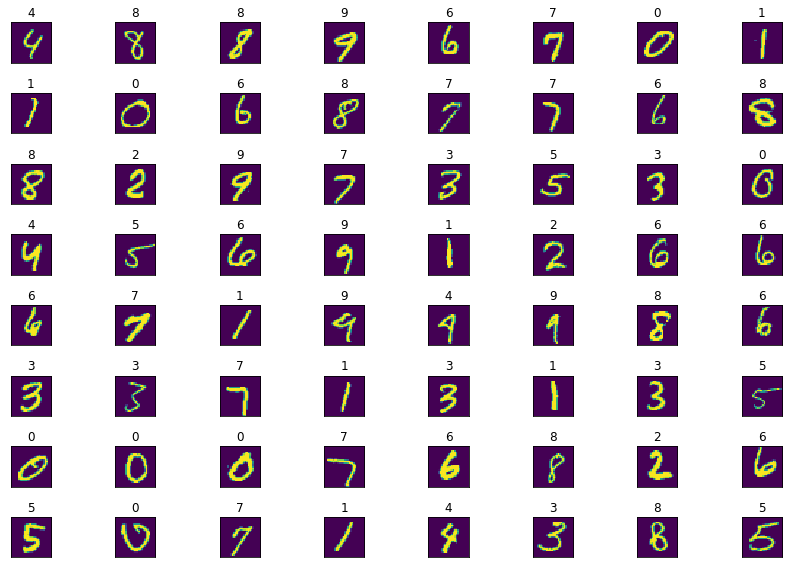

In [ ]:
# Plot batch of train images
fig = plt.figure(figsize=(12,8))
for idx in range(batch_size):
    n = np.rint(np.sqrt(batch_size))
    ax = fig.add_subplot(n, n, idx + 1, xticks=[], yticks=[])
    plt.imshow((images[idx][0] + 0.5) * 0.5)  # Un-normalise
    ax.set_title(labels[idx].item(), fontdict={"fontsize": 12})
plt.tight_layout()
plt.show()

In [ ]:
# Define the model
model = mlp.MLP((28 * 28, 512, 512, 10), 0.25)

# Move model to device
model = model.to(device)

In [ ]:
# Set optimizer and bind to model
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Define loss
loss = nn.NLLLoss()

Epoch: 0
    Training Loss: 0.090240    Validation Loss: 0.090240
        Validation loss decreased. Saving model...
Epoch: 1
    Training Loss: 0.067871    Validation Loss: 0.067871
        Validation loss decreased. Saving model...
Epoch: 2
    Training Loss: 0.059527    Validation Loss: 0.059527
        Validation loss decreased. Saving model...
Epoch: 3
    Training Loss: 0.054198    Validation Loss: 0.054198
        Validation loss decreased. Saving model...
Epoch: 4
    Training Loss: 0.049532    Validation Loss: 0.049532
        Validation loss decreased. Saving model...
Epoch: 5
    Training Loss: 0.045617    Validation Loss: 0.045617
        Validation loss decreased. Saving model...
Epoch: 6
    Training Loss: 0.040833    Validation Loss: 0.040833
        Validation loss decreased. Saving model...
Epoch: 7
    Training Loss: 0.037596    Validation Loss: 0.037596
        Validation loss decreased. Saving model...
Epoch: 8
    Training Loss: 0.035449    Validation Loss: 0.03544

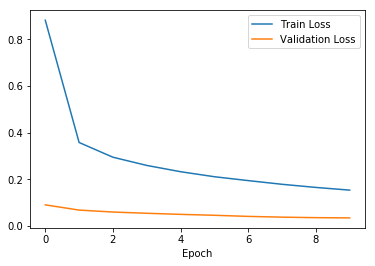

In [ ]:
# Train model
epochs = 10
model_name = "data/MNIST/mlp_mnist.pt"
if os.path.isfile(model_name):
    # Load the model
    model.load_state_dict(torch.load(model_name))
else:
    train_loss, validation_loss = train.train(
        epochs,
        model,
        loss,
        optimizer,
        train_loader,
        validation_loader,
        model_name,
        device,
    )

    # Show train and validation losses
    fig = plt.figure()
    plt.plot(range(epochs), train_loss, label="Train Loss")
    plt.plot(range(epochs), validation_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [ ]:
# Test the model
test_loss = 0.0
class_correct = list(range(10))
class_total = list(range(10))
model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    predicted = model(data)
    l = loss(predicted, target)
    test_loss += l.item() * data.size(0)
    _, pred = torch.max(predicted, dim=1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss / len(test_loader)
print(f"Test Loss: {test_loss:.6f}")
for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        num_correct = np.sum(class_correct[i])
        num_total = np.sum(class_total[i])
        print(f"Test Accuracy of {i}: {accuracy:.2f}% ({num_correct}/{num_total})")
    else:
        print(f"Test Accuracy of {classes[i]}: N/A")

Test Loss: 10.404069
Test Accuracy of 0: 98.06% (961/980)
Test Accuracy of 1: 97.89% (1112/1136)
Test Accuracy of 2: 94.78% (980/1034)
Test Accuracy of 3: 94.27% (955/1013)
Test Accuracy of 4: 97.16% (958/986)
Test Accuracy of 5: 92.20% (827/897)
Test Accuracy of 6: 96.89% (934/964)
Test Accuracy of 7: 93.04% (963/1035)
Test Accuracy of 8: 94.30% (926/982)
Test Accuracy of 9: 90.28% (919/1018)


# Load a batch of test images (and labels) and compute predictions
model = model.to("cpu")
test_iterator = iter(test_loader)
images, labels = test_iterator.next()
predicted = model(images)
_, preds = torch.max(predicted, dim=1)
images = images.numpy()

# Plot batch of test images
fig = plt.figure(figsize=(12,8))
for idx in range(batch_size):
    n = np.rint(np.sqrt(batch_size))
    ax = fig.add_subplot(n, n, idx + 1, xticks=[], yticks=[])
    plt.imshow((images[idx][0] + 0.5) * 0.5)  # Un-normalise
    ax.set_title(
        f"{preds[idx].item()} ({labels[idx].item()})",
        fontdict={"fontsize": 12},
        color=("green" if preds[idx] == labels[idx] else "red"),
    )
plt.tight_layout()
plt.show()
